## Step1. Map classical inputs to a quantum problem

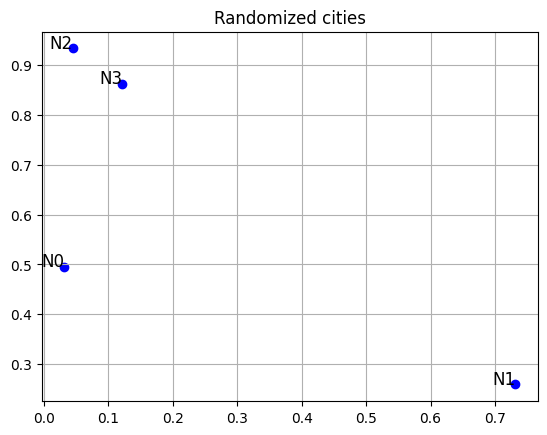

[[0 7 4 3]
 [7 0 9 8]
 [4 9 0 1]
 [3 8 1 0]]


In [2]:
from utils import randomize_cities, make_tsp, QISKIT_TOKEN
weights = randomize_cities(4)
weights = (weights * 10).astype(int)
print(weights)

In [2]:
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.circuit.library import EfficientSU2

qp = make_tsp(weights)
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
Hamiltonian, offset = qubo.to_ising()

ansatz = EfficientSU2(num_qubits=Hamiltonian.num_qubits, reps=1)
# ansatz.decompose().draw('mpl', style='iqp')
print(ansatz.num_parameters)

64


# Step 2. Optimize problem for quantum execution

In [3]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator


# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token=QISKIT_TOKEN)
backend = service.least_busy(operational=True, simulator=False)

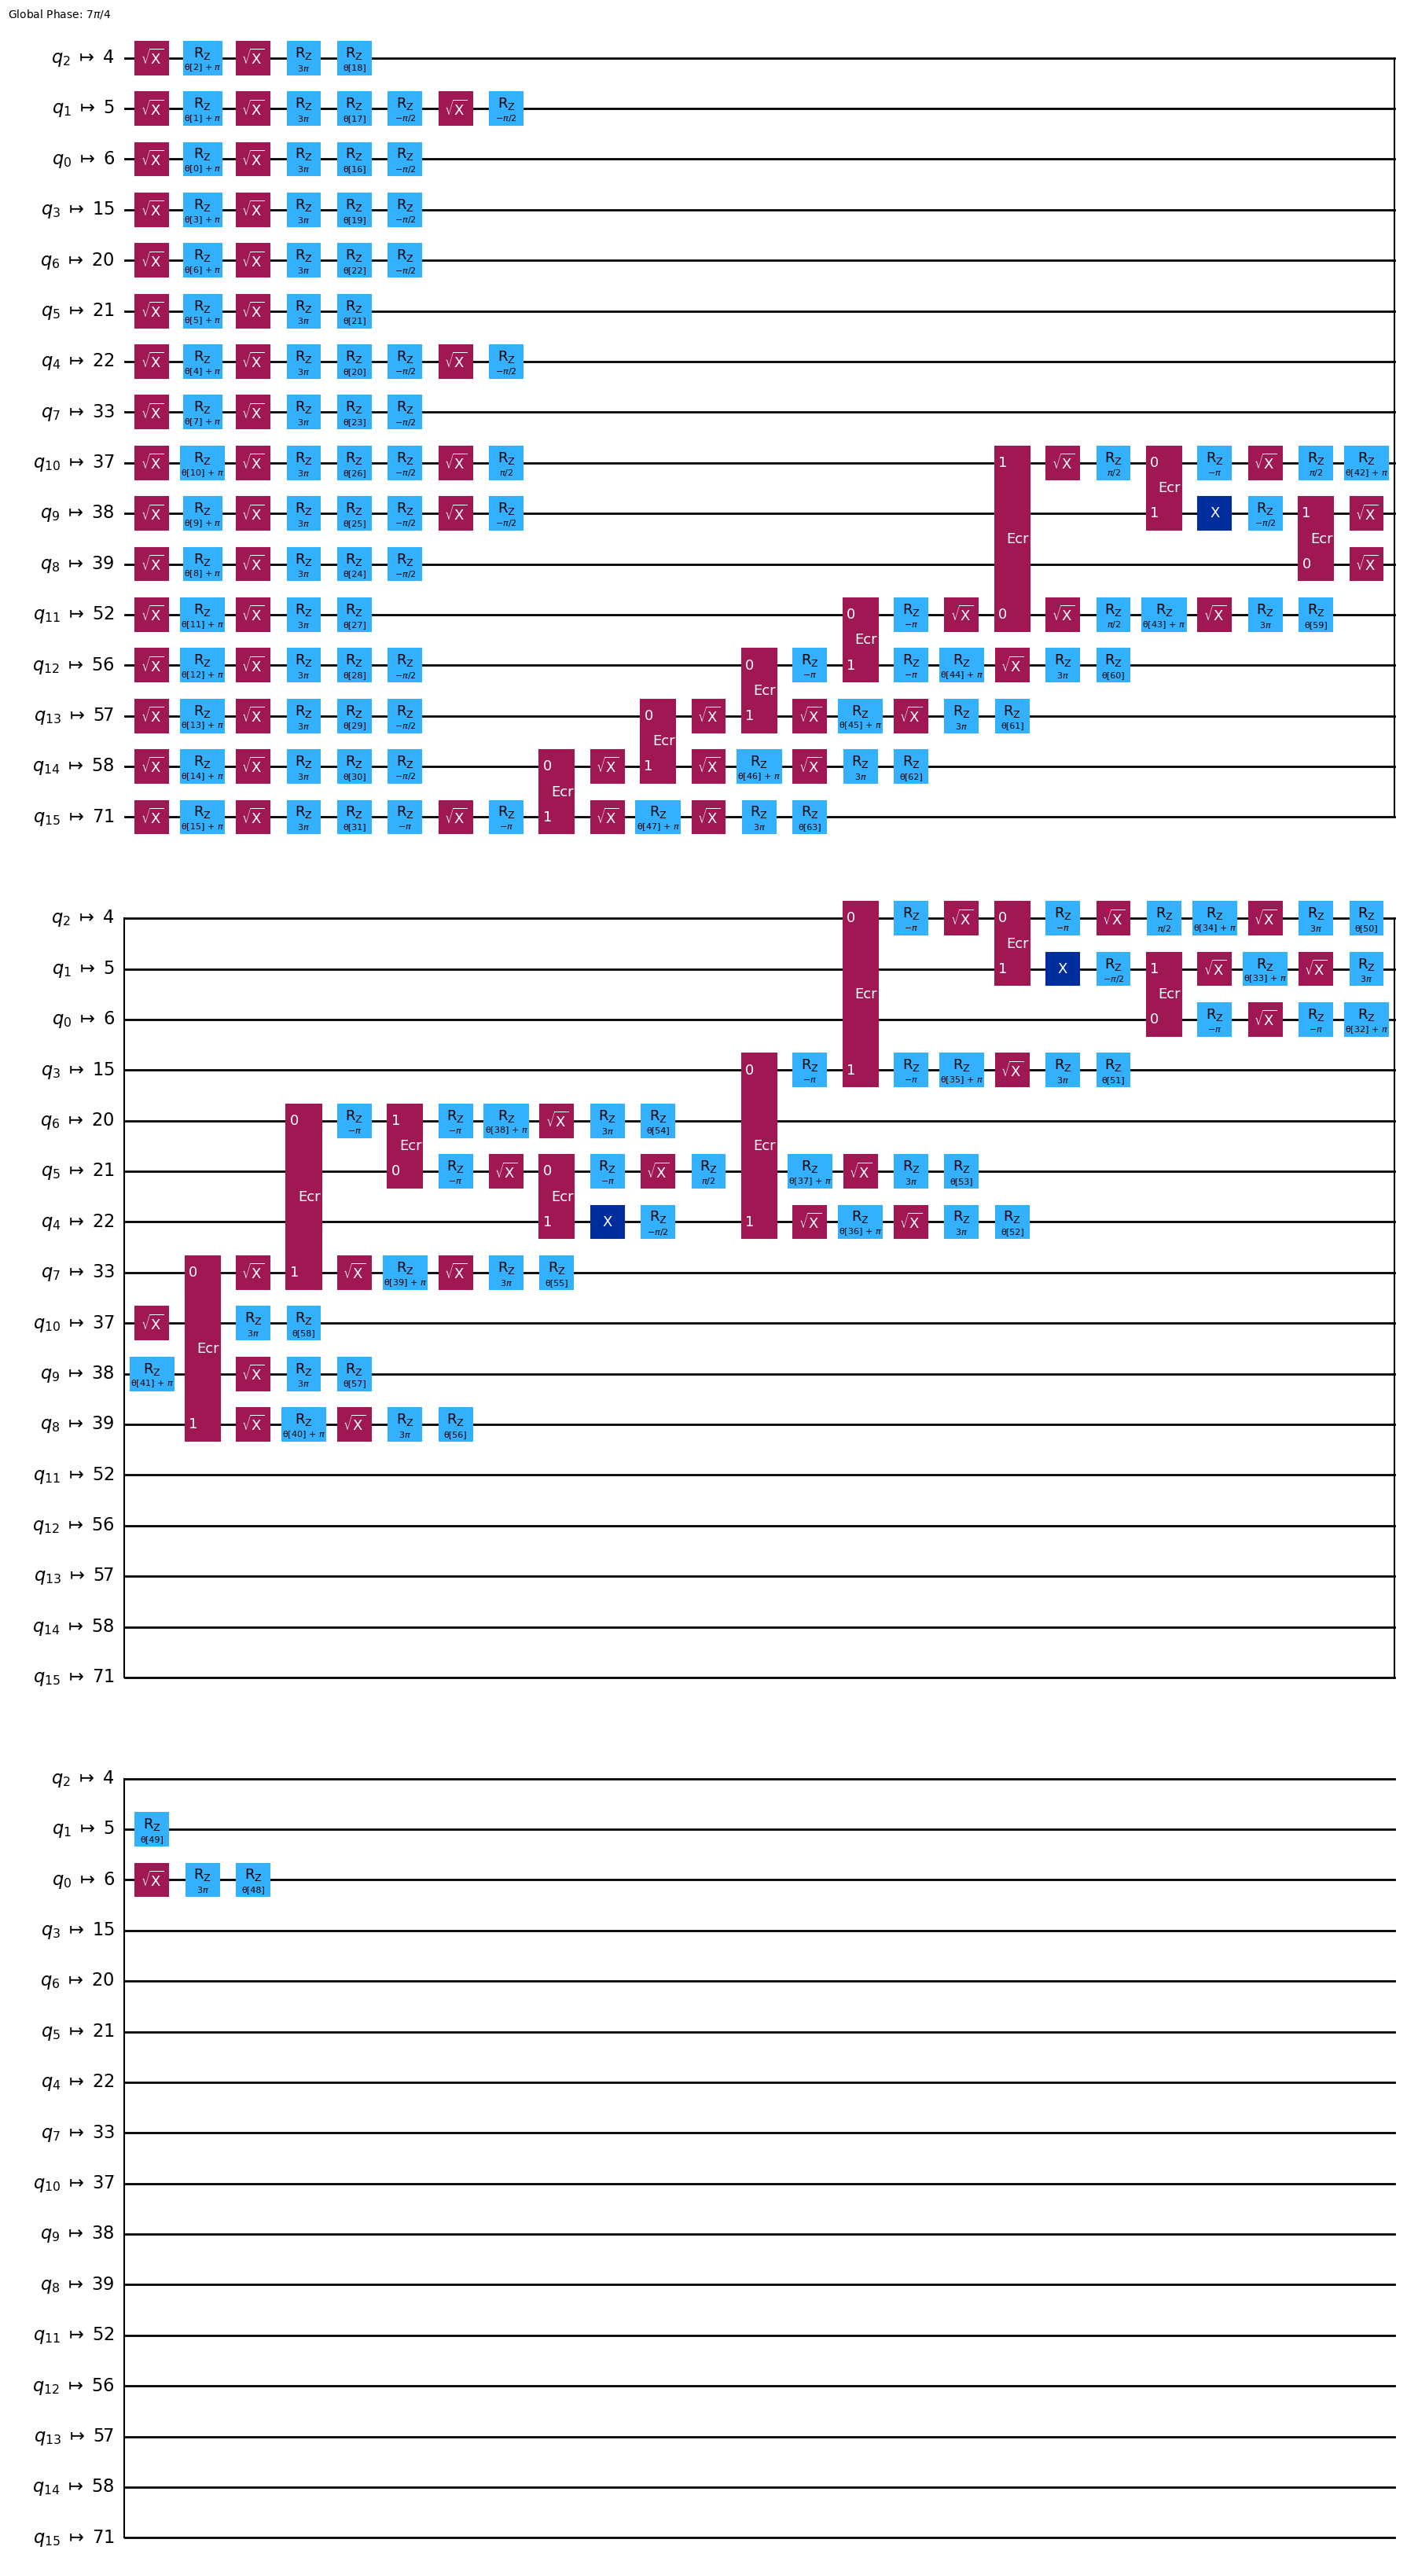

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [5]:
Hamiltonian_isa = Hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [6]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver

# Classical solver test
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
c_result = exact.solve(qp)
print(c_result.prettyprint())

objective function value: 13.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_0_3=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=0.0, x_1_3=1.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0, x_3_3=0.0
status: SUCCESS


# Step 3. Execute using Qiskit Primitives

In [7]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [8]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [9]:
import numpy as np
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
x0

array([1.30619703, 0.73542348, 2.53020954, 2.8075613 , 1.90483571,
       4.06083888, 0.17477768, 2.18588001, 2.02008282, 3.49536795,
       0.85983736, 2.76548666, 2.51045213, 2.77853146, 0.66122492,
       0.63894001, 1.93687578, 6.22018062, 5.34458332, 0.59745864,
       2.82633716, 1.45624007, 1.50266742, 2.45619579, 1.78357954,
       2.79658189, 0.08866759, 4.88095179, 0.92294238, 1.72717193,
       0.44236454, 0.52951544, 0.78523647, 1.75404636, 0.50758672,
       1.20345998, 4.21327876, 3.7327113 , 5.73054036, 2.63366231,
       5.13092152, 0.16227608, 3.34494924, 2.25394089, 1.1958421 ,
       3.43317168, 3.42329104, 0.64227428, 4.54563287, 5.68930996,
       3.74017908, 3.49882536, 3.08546087, 4.66318149, 0.82305567,
       1.05597556, 3.80766877, 1.87295119, 6.08307822, 0.5453447 ,
       5.65118723, 0.2728665 , 5.51758873, 1.10013657])

In [ ]:
from scipy.optimize import minimize

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, Hamiltonian_isa, estimator),
        method='L-BFGS-B',
    )
    print(res)

# Get Job

In [8]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from utils import QISKIT_TOKEN

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum", token=QISKIT_TOKEN)
job = service.job("cw8hdme9ezk000811020")

In [12]:
print(job.status())
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")


DONE
Expectation values for pub 0: [-186.93915941]


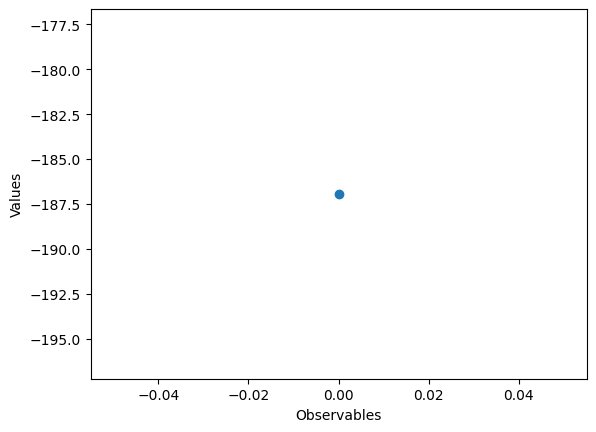

In [15]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot([i for i in range(1)], values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()